# Nature Conservancy Monitoring

## Set up training, validation and testing schemes
Images are in Train and Test folders. The idea is to read all the training images in memory and dump into a numpy array on disk.
So that we waste very little time when experimenting from scratch.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import cv2
import os
import glob
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adadelta, Adam
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, History
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from __future__ import division, print_function
from collections import Counter
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 5105)


## Create Validation directory

In [2]:
% cd /home/trooper/Documents/Nature
% rm -r train
% rm -r valid
% mkdir train valid
% cp -r train_orig/* train
% cd train

# pool_counter = 1

for fish_class in glob.glob('*'): os.mkdir('../valid/' + fish_class)

rnd_ord = np.random.permutation(glob.glob('*/*.jpg'))
for i in range(500): os.rename(rnd_ord[i], '../valid/' + rnd_ord[i])

/home/trooper/Documents/Nature
/home/trooper/Documents/Nature/train


## VGG Batchnorm

In [3]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def VGG_16(size=(224, 224), weights_path='/home/trooper/Documents/Nature/vgg16.h5'):
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,)+size))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

## Finetune

In [4]:
size = (224, 224)
model = VGG_16(size=size)
model.pop(); model.pop(); model.pop(); model.pop(); model.pop();

for layer in model.layers:
    layer.trainable = False

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

## Train, Validate generator

In [5]:
nb_train_samples = len(glob.glob('*/*.jpg'))
nb_validation_samples = len(glob.glob('../valid/*/*.jpg'))
nb_epoch = 50
bath_size = 16
nb_test_samples = 1000

classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        '../train/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
        '../valid/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=0)]
model.compile(loss='categorical_crossentropy', optimizer="adadelta", \
              metrics=["accuracy"])

# fine-tune the model
hist = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples,
        callbacks=callbacks)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Epoch 1/50
3277/3277 [==============================] - 135s - loss: 1.8742 - acc: 0.4544 - val_loss: 1.1314 - val_acc: 0.6640
Epoch 2/50
3277/3277 [==============================] - 127s - loss: 1.2246 - acc: 0.6204 - val_loss: 0.8689 - val_acc: 0.7300
Epoch 3/50
3277/3277 [==============================] - 129s - loss: 1.0054 - acc: 0.6677 - val_loss: 0.6905 - val_acc: 0.7960
Epoch 4/50
3277/3277 [==============================] - 127s - loss: 0.8529 - acc: 0.7202 - val_loss: 0.6134 - val_acc: 0.8180
Epoch 5/50
3277/3277 [==============================] - 127s - loss: 0.7680 - acc: 0.7479 - val_loss: 0.5316 - val_acc: 0.8340
Epoch 6/50
3277/3277 [==============================] - 127s - loss: 0.7163 - acc: 0.7531 - val_loss: 0.5715 - val_acc: 0.8480
Epoch 7/50
3277/3277 [==============================] - 125s - loss: 0.6584 - acc: 0.7711 - val_loss: 0.5128 - val_acc: 0.8400
Epoch 8/50
3277/3277 [======

## Plots

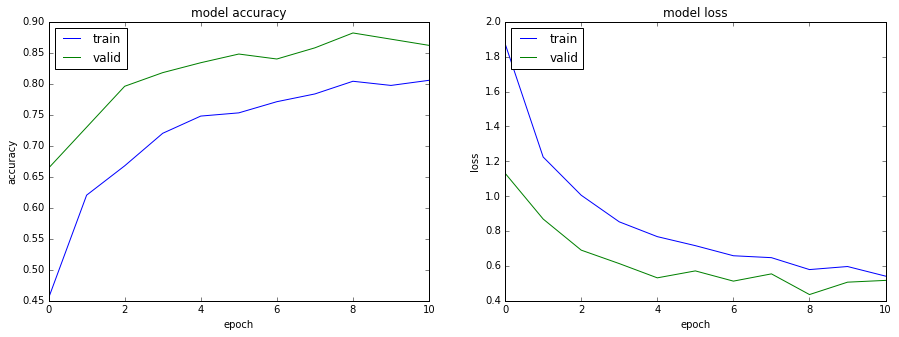

In [6]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [7]:
model.save_weights('../pickles/vgg16_aug_lessdrop.pkl')

## Test generator

In [9]:
test_aug = 5
test_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

for aug in range(test_aug):
    print('Predictions for Augmented -', aug)
    random_seed = np.random.random_integers(0, 100000)

    test_generator = test_datagen.flow_from_directory(
            '../test/',
            target_size=size,
            batch_size=bath_size,
            shuffle = False,
            seed = random_seed,
            classes = None,
            class_mode = None)

    test_image_list = test_generator.filenames
    if aug == 0:
        predictions = model.predict_generator(test_generator, nb_test_samples)
    else:
        predictions += model.predict_generator(test_generator, nb_test_samples)

predictions /= test_aug

Predictions for Augmented - 0
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 1
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 2
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 3
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 4
Found 1000 images belonging to 1 classes.


## Predictions

In [10]:
# clip predictions
c = 0
preds = np.clip(predictions, c, 1-c)

print('Begin to write submission file ..')
f_submit = open(os.path.join('/home/trooper/Documents/Nature/pooled', \
                             'submit_' + str(pool_counter) +'.csv'), 'w')
f_submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
for i, image_name in enumerate(test_generator.filenames):
    pred = ['%.6f' % p for p in preds[i, :]]
    if i%100 == 0:
        print(i, '/', 1000)
    f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

f_submit.close()

Begin to write submission file ..
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
